# Exercise 9: RNNs & More on Training Neural Networks with Keras

In [1]:
# Load packages we need
import sys
import os
import datetime

import numpy as np
import sklearn

import scipy as sp
import pandas as pd

import tensorflow as tf

# we'll use keras for neural networks
import tensorflow.keras as keras
from tensorflow.keras.datasets import fashion_mnist

# import layers we will use
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, SimpleRNN, GRU

# import callbacks we will use
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

# Load the TensorBoard notebook extension
%load_ext tensorboard

%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 18})

# Let's check our software versions
print('### Python version: ' + sys.version)
print('### Numpy version: ' + np.__version__)
print('### Scikit-learn version: ' + sklearn.__version__)
print('### Tensorflow version: ' + tf.__version__)
print('------------')


# load our packages / code
sys.path.insert(1, '../common/')
import utils
import plots

### Python version: 3.8.5 (default, Jan 27 2021, 15:41:15) 
[GCC 9.3.0]
### Numpy version: 1.19.5
### Scikit-learn version: 0.24.0
### Tensorflow version: 2.4.0
------------


In [2]:
# global parameters to control behavior of the pre-processing, ML, analysis, etc.

seed = 42 # deterministic seed
np.random.seed(seed) 
tf.random.set_seed(seed)

prop_vec = [24, 2, 2]

## Let's use Fashion MNIST

In [158]:
def load_preprocess_fashion_mnist(minmax_normalize=True):
    
    labels = ['top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    train, testval = fashion_mnist.load_data()
    
    train_x, train_y = train
    testval_x, testval_y = testval
    
    if minmax_normalize:
        train_x = train_x / 255.0
        testval_x = testval_x / 255.0
    
    # split test - val
    nval = testval_x.shape[0] // 2
    
    val_x = testval_x[:nval]
    val_y = testval_y[:nval]
    
    test_x = testval_x[nval:]
    test_y = testval_y[nval:]
    
    return train_x, train_y, test_x, test_y, val_x, val_y, np.array(labels)

In [159]:
train_x, train_y, test_x, test_y, val_x, val_y, labels = load_preprocess_fashion_mnist()

### What does the data look like?

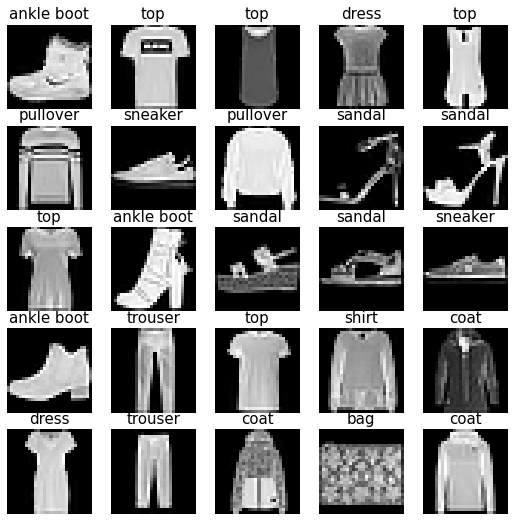

In [160]:
num_images = 25
label_idx = train_y[:num_images].astype(int)
titles = labels[label_idx]
plots.plot_images(train_x[:num_images].reshape(-1, 28, 28), dim_x=28, dim_y=28, fig_size=(9,9), titles=titles)

In [161]:
# subclass for l4 regularization
class L4Regularizer(keras.regularizers.Regularizer):
    def __init__(self, lmbda):
        self.lmbda = lmbda

    # for regularizers, constraints, etc. need to define __call__()
    def __call__(self, weights):
        return self.lmbda * tf.reduce_sum(tf.pow(weights, 4.0))
    
    # this for config so we can save/load
    def get_config(self):
        return {'lmbda': self.lmbda}
    
    
# force the weights to be binary (+1 or -1)
def binary_weights_constraint(weights):
    return tf.where(weights >= 0.0, tf.ones_like(weights), -tf.ones_like(weights))

In [162]:
def create_model_functional(input_shape=(28, 28)):  
    
    # let's use the functional API to create a model
    input_layer = Input(shape=input_shape, name='Input')
    
    flatten_layer = Flatten(name='Flatten')(input_layer)
    fc1 = Dense(300, name='FC1', activation='relu', kernel_regularizer=L4Regularizer(0.01), kernel_constraint=binary_weights_constraint)(flatten_layer)
    fc2 = Dense(100, name='FC2', activation='relu', kernel_regularizer=L4Regularizer(0.01), kernel_constraint=binary_weights_constraint)(fc1)
    output_layer = Dense(10, name='Output', activation='softmax')(fc2)
    
    model = keras.Model(name='FC-model', inputs=[input_layer], outputs=[output_layer])
    
    return model

In [163]:
model = create_model_functional()

In [164]:
# what does the model look like?
model.summary()

Model: "FC-model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 28, 28)]          0         
_________________________________________________________________
Flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
FC1 (Dense)                  (None, 300)               235500    
_________________________________________________________________
FC2 (Dense)                  (None, 100)               30100     
_________________________________________________________________
Output (Dense)               (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


## Let's compile and train the model

In [168]:
# compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [169]:
max_epochs = 30
batch_size = 64
history = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=max_epochs, batch_size=batch_size)

Epoch 1/30
938/938 [==============================] - 3s 3ms/step - loss: 2670.4795 - accuracy: 0.5827 - val_loss: 2660.5857 - val_accuracy: 0.6880
Epoch 2/30
938/938 [==============================] - 3s 3ms/step - loss: 2657.8535 - accuracy: 0.7159 - val_loss: 2657.4397 - val_accuracy: 0.7032
Epoch 3/30
938/938 [==============================] - 3s 3ms/step - loss: 2655.2952 - accuracy: 0.7337 - val_loss: 2654.6477 - val_accuracy: 0.7258
Epoch 4/30
938/938 [==============================] - 3s 3ms/step - loss: 2654.0513 - accuracy: 0.7382 - val_loss: 2653.9431 - val_accuracy: 0.7230
Epoch 5/30
938/938 [==============================] - 3s 3ms/step - loss: 2653.4390 - accuracy: 0.7385 - val_loss: 2653.3567 - val_accuracy: 0.7292
Epoch 6/30
938/938 [==============================] - 3s 3ms/step - loss: 2653.1960 - accuracy: 0.7391 - val_loss: 2653.3384 - val_accuracy: 0.7056
Epoch 7/30
938/938 [==============================] - 3s 3ms/step - loss: 2653.1016 - accuracy: 0.7391 - val_los

In [170]:
# how good is our model?
loss, acc = model.evaluate(test_x, test_y)

157/157 [==============================] - 0s 2ms/step - loss: 2652.9685 - accuracy: 0.7376


In [171]:
# check the weights
weights, biases = model.get_layer('FC1').get_weights()

In [172]:
weights, weights.shape

(array([[ 1., -1., -1., ..., -1.,  1., -1.],
        [ 1., -1., -1., ...,  1., -1., -1.],
        [-1., -1.,  1., ..., -1.,  1., -1.],
        ...,
        [-1.,  1., -1., ..., -1.,  1.,  1.],
        [ 1., -1.,  1., ..., -1.,  1.,  1.],
        [-1.,  1., -1., ..., -1.,  1., -1.]], dtype=float32),
 (784, 300))

In [173]:
biases, biases.shape

(array([-1.7007846e+00, -1.0846454e+00,  5.0806278e-01, -5.9222782e-01,
         2.4628791e-01, -1.3788934e+00, -1.7072674e+00,  4.5303604e-01,
         2.6681837e-01, -1.7718064e+00,  1.3215802e+00,  1.8442409e-01,
        -2.0115683e+00,  1.2035661e+00, -5.9820497e-01,  1.3215733e+00,
         3.6294457e-01, -3.2006949e-01, -9.3912266e-02, -5.5708069e-01,
         3.2022431e-01, -2.4112253e+00, -6.8362415e-01, -2.4513445e+00,
        -8.9394055e-02, -8.5973269e-01,  1.7037605e-01, -2.9857516e+00,
         1.2264327e+00, -2.1445341e+00, -1.7067919e+00, -9.5114219e-01,
        -2.8232617e+00, -1.7507242e+00,  1.4783562e+00, -1.7614222e+00,
         7.1189016e-01, -8.7640369e-01, -1.1485026e+00, -1.9444258e+00,
        -1.5672660e+00, -4.3136554e+00, -3.2636471e+00, -1.7489592e+00,
         7.5047976e-01, -2.0726335e+00, -1.1887763e+00,  8.9635938e-01,
        -6.4972550e-01, -4.2019310e+00,  2.1351945e+00, -2.2848177e+00,
         6.5090704e-01, -2.6231018e-01, -2.2379084e+00, -3.76282

### Can we use a RNN to predict stock prices?
#### Note: this data is synthetic.

In [3]:
fp = '../data/stock-data.csv'
stock_data = np.loadtxt(fp, delimiter=',')

In [4]:
# split into features and target
all_x = stock_data[:,:-1]
all_y = stock_data[:,-1]

In [5]:
train_x, train_y, test_x, test_y, val_x, val_y = utils.train_test_val_split(all_x, all_y, prop_vec, shuffle=True)

### What does the data look like?

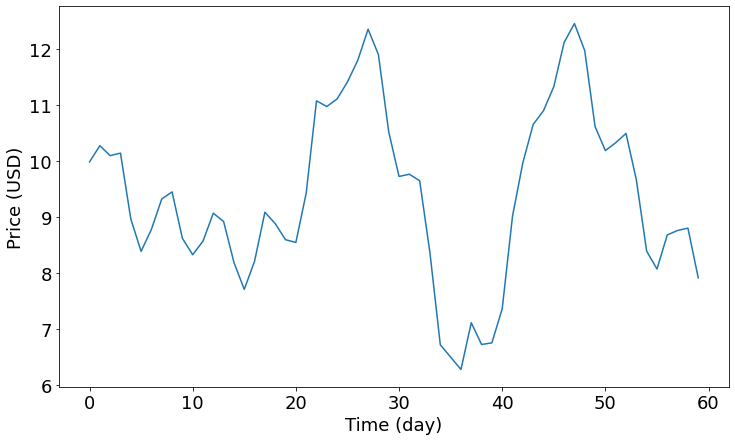

In [6]:
fig = plt.figure(figsize=(12,7))
plt.plot(np.arange(0, train_x.shape[1]), train_x[0])
plt.xlabel('Time (day)')
plt.ylabel('Price (USD)')
plt.show()

### Let's reshape the data if necessary

In [7]:
if len(train_x.shape) < 3:
    train_x = train_x[:,:,np.newaxis]
    val_x = val_x[:,:,np.newaxis]
    test_x = test_x[:,:,np.newaxis]

In [8]:
def create_compile_rnn(input_shape=(None,1), verbose=True):
    name = 'Simple-RNN'

    model = keras.models.Sequential(name=name)

    model.add(keras.Input(shape=input_shape, name='input')) 
    
    model.add(SimpleRNN(32, return_sequences=True, name='rnn1'))
    model.add(SimpleRNN(32, name='rnn2'))
    
    # output
    model.add(Dense(1, activation='linear', name='output'))
    
    if verbose:
        model.summary()
        
    opt = keras.optimizers.Adam(lr=0.001)
    model.compile(loss='mse', optimizer=opt, metrics=['mae'])
    
    return model

In [9]:
model = create_compile_rnn()

Model: "Simple-RNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn1 (SimpleRNN)             (None, None, 32)          1088      
_________________________________________________________________
rnn2 (SimpleRNN)             (None, 32)                2080      
_________________________________________________________________
output (Dense)               (None, 1)                 33        
Total params: 3,201
Trainable params: 3,201
Non-trainable params: 0
_________________________________________________________________


In [10]:
num_epochs = 30
batch_size = 100

hist = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=num_epochs, batch_size=batch_size, callbacks=[])

Epoch 1/30
60/60 [==============================] - 2s 18ms/step - loss: 56.3561 - mae: 6.9652 - val_loss: 9.5879 - val_mae: 2.7004
Epoch 2/30
60/60 [==============================] - 1s 12ms/step - loss: 7.8024 - mae: 2.3793 - val_loss: 4.0878 - val_mae: 1.6702
Epoch 3/30
60/60 [==============================] - 1s 12ms/step - loss: 3.6830 - mae: 1.5778 - val_loss: 2.7122 - val_mae: 1.3567
Epoch 4/30
60/60 [==============================] - 1s 13ms/step - loss: 2.7602 - mae: 1.3762 - val_loss: 2.4579 - val_mae: 1.2918
Epoch 5/30
60/60 [==============================] - 1s 13ms/step - loss: 2.5624 - mae: 1.3326 - val_loss: 2.4158 - val_mae: 1.2794
Epoch 6/30
60/60 [==============================] - 1s 13ms/step - loss: 2.5384 - mae: 1.3208 - val_loss: 2.3296 - val_mae: 1.2566
Epoch 7/30
60/60 [==============================] - 1s 13ms/step - loss: 2.2187 - mae: 1.2274 - val_loss: 1.5643 - val_mae: 1.0236
Epoch 8/30
60/60 [==============================] - 1s 13ms/step - loss: 1.4258 - 

In [11]:
val_preds = model.predict(val_x).ravel()

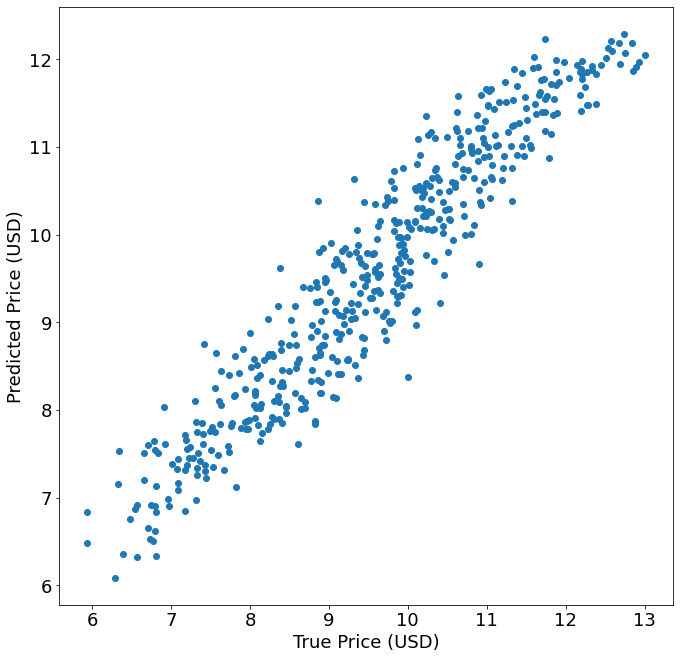

In [12]:
fig = plt.figure(figsize=(11,11))
plt.scatter(val_y, val_preds)
plt.xlabel('True Price (USD)')
plt.ylabel('Predicted Price (USD)')
plt.show()

## Training a Character-level RNN

### For this we'll use the text of Wizard of Oz books

In [45]:
def split_data_seq_target(seq_array, window_size, slide=1):
    seq_length = seq_array.shape[0]
    num_examples_slide1 = seq_length - window_size
    x = np.zeros((num_examples_slide1, window_size), dtype=np.uint8)
    y = np.zeros((num_examples_slide1,1), dtype=np.uint8)
    idx = 0
    for i in range(0, num_examples_slide1, slide):
        x[idx,:] = seq_array[i:i+window_size]
        y[idx] = seq_array[i+window_size]
        idx += 1

    return x[:idx], y[:idx]

def to_array(tokenizer, input_string_array, verbose=0):
    # encode as an sequence (array) of integers
    seq_list = tokenizer.texts_to_sequences(input_string_array)
    # remap to 0 to max_id -1
    encoded_array = np.array(seq_list[0], dtype=np.uint8) - 1 # subtract 1 because indices start at 1
    if verbose:
        print(encoded_array, encoded_array.shape, np.amin(encoded_array), np.amax(encoded_array))
    return encoded_array

def to_str(tokenizer, array):
     return tokenizer.sequences_to_texts(array + 1) # add 1 because indices start at 1

def load_preprocess_data(fp = '../data/oz-data.txt', window_size=150, verbose=0):
    with open(fp) as f:
        input_text = f.read()

    tokenizer = keras.preprocessing.text.Tokenizer(char_level=True, lower=False)
    tokenizer.fit_on_texts(input_text)

    num_classes = len(tokenizer.word_index)
    
    # encode as an sequence (array) of integers
    seq_array = to_array(tokenizer, [input_text], verbose)
    
    # split into windows
    x, y = split_data_seq_target(seq_array, window_size, slide=1)
    
    return x, y, int(num_classes), tokenizer

### We want to split this data into train, val, test 

### What could go wrong if we split randomly (e.g., shuffle x & y, then split)?

In [46]:
def train_test_split_seq(x, y, prop_vec=prop_vec, verbose=0):
    # instead we take the data in order
    n_tr = int(prop_vec[0] / np.sum(prop_vec) * x.shape[0])
    n_val = int(prop_vec[1] / np.sum(prop_vec) * x.shape[0])
    train_x = x[:n_tr]
    train_y = y[:n_tr]
    val_x = x[n_tr:n_tr+n_val]
    val_y = y[n_tr:n_tr+n_val]
    test_x = x[n_tr+n_val:]
    test_y = y[n_tr+n_val:]

    if verbose:
        print(train_x.shape, train_y.shape, val_x.shape, val_y.shape, test_x.shape, test_y.shape)
        
    return train_x, train_y, val_x, val_y, test_x, test_y

In [47]:
x, y, num_classes, tokenizer = load_preprocess_data()
train_x, train_y, val_x, val_y, test_x, test_y = train_test_split_seq(x, y)

In [48]:
print(train_x.shape, train_y.shape)

(1733181, 150) (1733181, 1)


### We need to one-hot encode the data

In [49]:
def make_ds_and_onehot(x, y, num_classes, batch_size=100, prefetch_size=10):
    ds = tf.data.Dataset.from_tensor_slices(np.c_[x, y])
    ds = ds.map(lambda batch_xy: (batch_xy[:-1], batch_xy[-1]))
    ds = ds.map(lambda batch_x, batch_y: (tf.one_hot(batch_x, depth=num_classes), batch_y))   
    
    # shuffle, batch, and prefetch
    ds = ds.shuffle(4096).batch(batch_size)
    ds = ds.prefetch(prefetch_size)
    return ds

In [50]:
ds_train = make_ds_and_onehot(train_x, train_y, num_classes)
ds_test = make_ds_and_onehot(test_x, test_y, num_classes)
ds_val = make_ds_and_onehot(val_x, val_y, num_classes)

In [51]:
ds_train

<PrefetchDataset shapes: ((None, 150, 80), (None,)), types: (tf.float32, tf.uint8)>

In [52]:
for x, y in ds_train.take(2):
    print(x, y)

tf.Tensor(
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]]

In [53]:
print(ds_train)

<PrefetchDataset shapes: ((None, 150, 80), (None,)), types: (tf.float32, tf.uint8)>


### Let's create a model

In [59]:
def create_compile_rnn(input_shape=(None, num_classes), dropout_rate=0.175, verbose=True):
    name = 'CharLevel-RNN'

    model = keras.models.Sequential(name=name)

    model.add(keras.Input(shape=input_shape, sparse=False, name='input')) 
    
    model.add(GRU(192, return_sequences=True, dropout=dropout_rate, recurrent_dropout=0.0, name='gru1'))
    model.add(GRU(128, recurrent_dropout=0.0, name='gru2'))
    
    # output
    model.add(Dense(num_classes, activation='softmax', name='output'))
    
    if verbose:
        model.summary()
        
    opt = keras.optimizers.Adam(lr=0.001)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

In [60]:
model_fp = './charlevel-rnn.h5'

train = False
#train = True

if train:
    model = create_compile_rnn()
    
    num_epochs = 20
    history = model.fit(ds_train, validation_data=ds_val, epochs=num_epochs, callbacks=[])
    
    model.save(model_fp) # save the model
else:
    assert os.path.exists(model_fp), 'Train the model first!'
    
    model = keras.models.load_model(model_fp)

Model: "Simple-RNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru1 (GRU)                   (None, None, 192)         157824    
_________________________________________________________________
gru2 (GRU)                   (None, 128)               123648    
_________________________________________________________________
output (Dense)               (None, 80)                10320     
Total params: 291,792
Trainable params: 291,792
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
17332/17332 [==============================] - 428s 25ms/step - loss: 1.8069 - accuracy: 0.4748 - val_loss: 1.5991 - val_accuracy: 0.5375
Epoch 2/20
17332/17332 [==============================] - 429s 25ms/step - loss: 1.5728 - accuracy: 0.5317 - val_loss: 1.5154 - val_accuracy: 0.5586
Epoch 3/20
17332/17332 [==============================] - 429s 25ms/step - loss: 1

In [61]:
def create_prompt(prompt):
    prompt_array = to_array(tokenizer, prompt).reshape(len(prompt), -1)
    return tf.one_hot(prompt_array, depth=num_classes)

In [62]:
prompt = create_prompt(['Doroth'])
prompt_pred = np.argmax(model.predict(prompt), axis=-1)

In [63]:
to_str(tokenizer, prompt_pred.reshape(-1, 1))

['y']

### Let's generate some text

In [64]:
def sample_from_model(model, prompt_str, out_len=50, temp=1.0):
    res = ''
    for i in range(0, out_len):
        prompt = create_prompt([prompt_str + res])
        
        # get the logits and compute softmax probabilities
        prob_vec = model.predict(prompt).reshape(-1,)
        logits_vec = np.log(prob_vec)/temp
        sample_probas = np.exp(logits_vec)
        sample_probas = sample_probas / np.sum(sample_probas)
        
        # use numpy to sample index according to sample_probas
        choice_idx = np.random.choice(np.arange(0, sample_probas.shape[0]), size=1, p=sample_probas)
        
        chosen_char = to_str(tokenizer, np.array([choice_idx]))[0]
        res += chosen_char
    return res

In [65]:
sample_from_model(model, 'Dorothy said', out_len=100, temp=0.7)

':\n\n"There was his balloon was a great Tunter of the Loons and looked at him.\n\n"Very well," said the '